In [1]:
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## ARMA

First, let's simulate an ARMA(2,2) process

In [2]:
ar2 = np.array([1, 0.5, 0.3])
ma2 = np.array([1, 0.2, 0.4])
nobs = 200
y = arma_generate_sample(ar2, ma2, nobs)

In [3]:
# add date as index
dates = pd.date_range('2000-1-1', freq="M", periods=nobs)
y = pd.Series(y, index=dates)
y.head().append(y.tail())

2000-01-31   -1.059850
2000-02-29    0.398996
2000-03-31   -0.195345
2000-04-30    1.207344
2000-05-31   -0.490988
2016-04-30    0.851238
2016-05-31    0.054701
2016-06-30    0.550991
2016-07-31    0.292678
2016-08-31    0.009648
dtype: float64

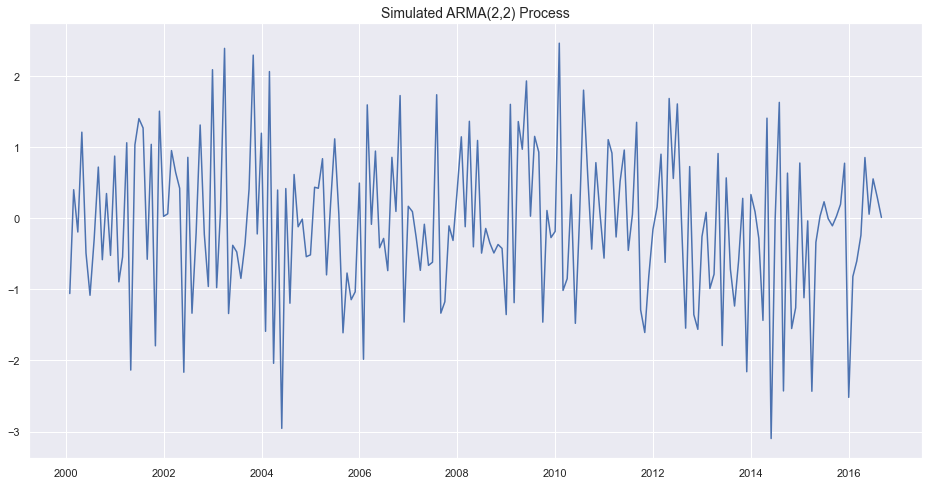

In [4]:
# visualize the data
plt.figure(figsize=[16, 8])
plt.plot(y)
plt.title("Simulated ARMA(2,2) Process",fontsize=14)
plt.show();

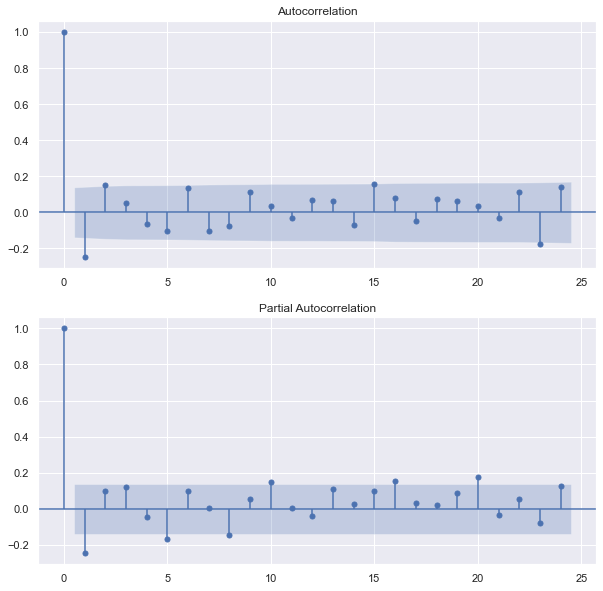

In [5]:
# Plot ACF and PACF
plt.figure(figsize = (10, 10))
plt.subplot(2,1,1); plot_acf(y, ax = plt.gca())
plt.subplot(2,1,2); plot_pacf(y,ax = plt.gca());

**Now, let's take a look at the US Wholesale Price Index Data**

In [6]:
# Fetch Data
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t

# Set the frequency
data.index.freq="QS-OCT"
data.head().append(data.tail())

,wpi,t,ln_wpi
t,,,
1960-01-01,30.700001,1960-01-01,3.424263
1960-04-01,30.799999,1960-04-01,3.427515
1960-07-01,30.700001,1960-07-01,3.424263
1960-10-01,30.700001,1960-10-01,3.424263
1961-01-01,30.799999,1961-01-01,3.427515
1989-10-01,109.400002,1989-10-01,4.695011
1990-01-01,111.000000,1990-01-01,4.709530
1990-04-01,110.800003,1990-04-01,4.707727
1990-07-01,112.800003,1990-07-01,4.725616


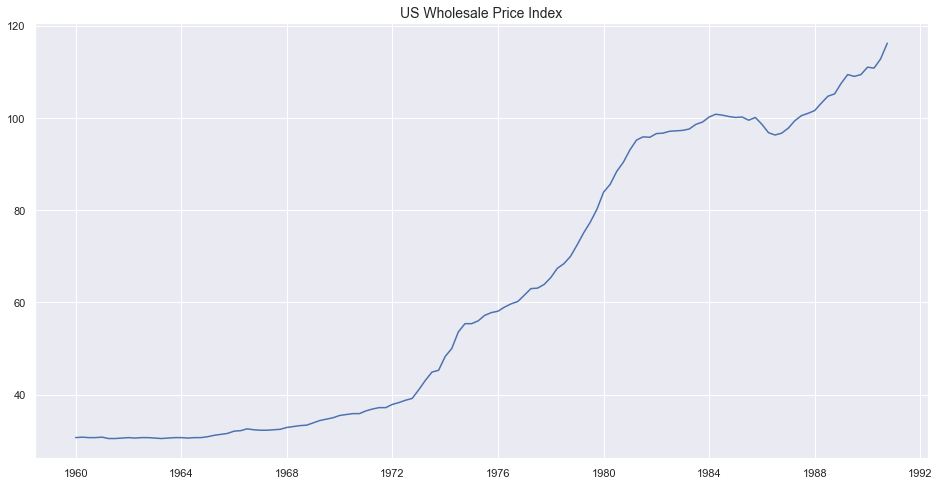

In [7]:
# visualize the data
plt.figure(figsize=[16, 8])
plt.plot(data.index,data['wpi'] )
plt.title("US Wholesale Price Index", fontsize=14)
plt.show();

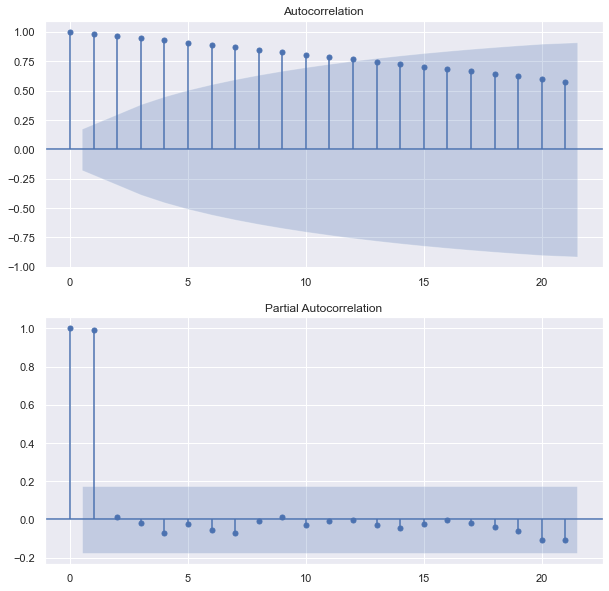

In [8]:
# Plot ACF and PACF
plt.figure(figsize = (10, 10))
plt.subplot(2,1,1); plot_acf(data['wpi'], ax = plt.gca())
plt.subplot(2,1,2); plot_pacf(data['wpi'],ax = plt.gca());

Clearly,there is a trend in the US WPI data over time. The ACF plot also indicates a high order of autocorrelations. We can use ADF test to prove it.

In [9]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(data['wpi'])
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')

ADF Statistic: 0.5872455370299964
p-value: 0.9872969979129654


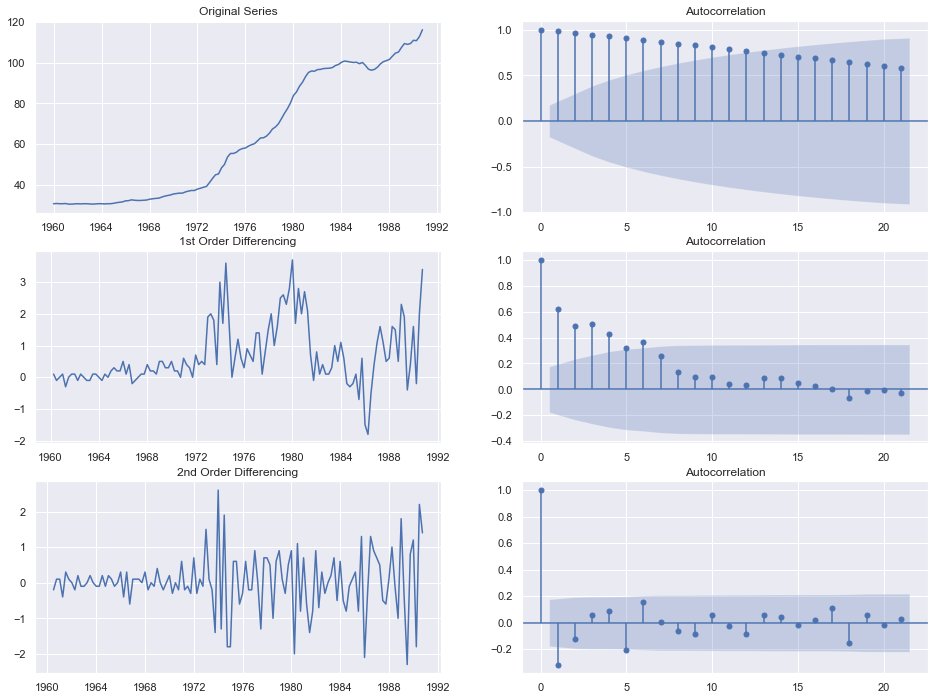

In [10]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(16,12))
axes[0, 0].plot(data['wpi']) 
axes[0, 0].set_title('Original Series')
plot_acf(data['wpi'], ax= axes[0,1])

#1st Differencing
axes[1, 0].plot(data['wpi'].diff()) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(data['wpi'].diff().dropna(), ax=axes[1, 1])

#2nd Differencing
axes[2, 0].plot(data['wpi'].diff().diff()) 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data['wpi'].diff().diff().dropna(), ax=axes[2, 1])

plt.show();

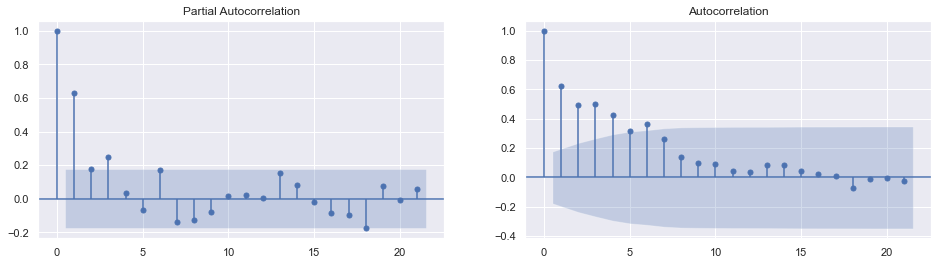

In [11]:
# Plot ACF and PACF
plt.figure(figsize = (16, 4))

plt.subplot(1,2,1); 
plot_pacf(data['wpi'].diff().dropna(), ax = plt.gca())
plt.subplot(1,2,2); 
plot_acf(data['wpi'].diff().dropna(),ax = plt.gca());

## ARIMA

In [12]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA(1,1,4) Model
model = ARIMA(data['wpi'], order=(1,1,4))
result = model.fit(disp=0, trend='c')
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.wpi   No. Observations:                  123
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -133.521
Method:                       css-mle   S.D. of innovations              0.713
Date:                Sat, 03 Jul 2021   AIC                            281.042
Time:                        19:51:27   BIC                            300.727
Sample:                    04-01-1960   HQIC                           289.038
                         - 10-01-1990                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7454      0.275      2.708      0.007       0.206       1.285
ar.L1.D.wpi     0.8047      0.085      9.462      0.000       0.638       0.971
ma.L1.D.wpi    -0.3149      0.120     -2.618    

The results indicate that the coefficients for MA(q) L2, L3, and L4 not statistically significant (i.e. p>0.05), we should revise the order of q to Lag 1 only.

In [13]:
# ARIMA(1,1,1) Model
model = ARIMA(data['wpi'], order=(1,1,1))
result = model.fit(disp=0,trend='c')
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.wpi   No. Observations:                  123
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -135.351
Method:                       css-mle   S.D. of innovations              0.725
Date:                Fri, 26 Feb 2021   AIC                            278.703
Time:                        00:09:53   BIC                            289.951
Sample:                    04-01-1960   HQIC                           283.272
                         - 10-01-1990                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7498      0.292      2.567      0.010       0.177       1.322
ar.L1.D.wpi     0.8742      0.064     13.707      0.000       0.749       0.999
ma.L1.D.wpi    -0.4120      0.122     -3.375    

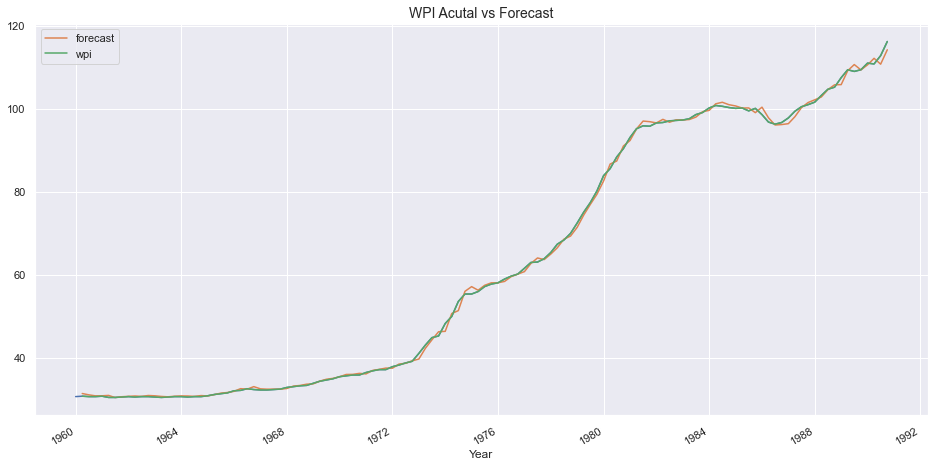

In [13]:
#Comparing Acutal vs. Forecast
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(data.index,data['wpi'])
result.plot_predict(ax=ax)
ax.set_xlabel('Year')
ax.set_title("WPI Acutal vs Forecast", fontsize=14)
plt.show();

## Auto ARIMA

In [14]:
import pmdarima as pm

model = pm.auto_arima(data['wpi'], start_p=1, start_q=1,
                 max_p=10, max_q=10,   #maximum p and q          
                 d=None,               #let the model determine d
                 seasonal=False,       #default is True
                 D=None, 
                 trace=True,
                 error_action='ignore',  
                 suppress_warnings=True, 
                 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=280.732, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=299.862, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=288.831, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=279.802, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=297.997, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=280.375, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=278.124, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=279.092, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=278.728, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=287.049, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.571 seconds


In [16]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -137.062
Date:                Fri, 26 Feb 2021   AIC                            278.124
Time:                        00:09:54   BIC                            283.732
Sample:                             0   HQIC                           280.402
                                - 124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5105      0.072     -7.086      0.000      -0.652      -0.369
sigma2         0.5524      0.055     10.058      0.000       0.445       0.660
Ljung-Box (L1) (Q):                   0.21   Jarque-

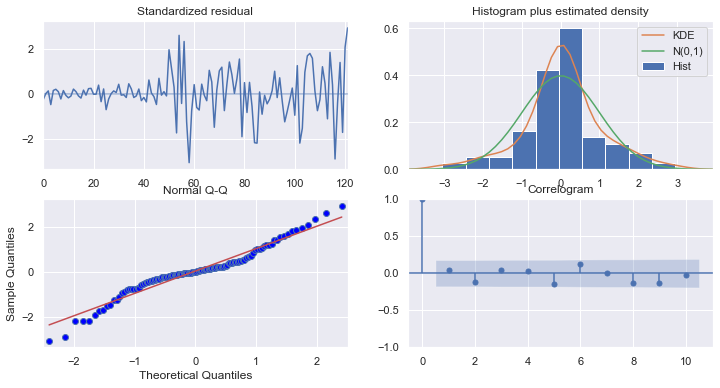

In [17]:
model.plot_diagnostics(figsize=(12, 6))
plt.show();

In [18]:
# predict next 10 periods
fc = model.predict(n_periods=10, return_conf_int=False)
fc

array([118.48017369, 120.76035043, 123.04052717, 125.32070392,
       127.60088066, 129.8810574 , 132.16123414, 134.44141088,
       136.72158762, 139.00176437])

## Forecast with ARIMA

**Let's re-run the model with statsmodels' ARIMA model and generate some in-sample and out-of sample forecasts**

In [19]:
# Re-run the ARIMA(0,2,1) Model
res = ARIMA(data['wpi'], order=(0,2,1)).fit()
# Predict a differenced forecast
print(res.predict(start='1989Q4', end='1992Q4'))

1989-07-01   -0.120211
1989-10-01    1.136837
1990-01-01    0.191553
1990-04-01   -0.498463
1990-07-01    0.686363
1990-10-01   -0.757584
1991-01-01   -1.087874
1991-04-01    0.018785
1991-07-01    0.018785
1991-10-01    0.018785
1992-01-01    0.018785
1992-04-01    0.018785
1992-07-01    0.018785
1992-10-01    0.018785
Freq: QS-OCT, dtype: float64


In [20]:
# Predict the levels of the original endogenous variables
print(res.predict(start='1989Q4', end='1992Q4',typ='levels'))

1989-07-01    111.179792
1989-10-01    109.736836
1990-01-01    109.991556
1990-04-01    112.101535
1990-07-01    111.286369
1990-10-01    114.042419
1991-01-01    118.512117
1991-04-01    120.843022
1991-07-01    123.192711
1991-10-01    125.561185
1992-01-01    127.948444
1992-04-01    130.354488
1992-07-01    132.779317
1992-10-01    135.222930
Freq: QS-OCT, dtype: float64


In [21]:
# Predict out-of-sample forecast using forecast() method
print(res.forecast(steps=8)[0])

[118.51211695 120.84302171 123.1927112  125.56118544 127.94844443
 130.35448816 132.77931664 135.22292987]


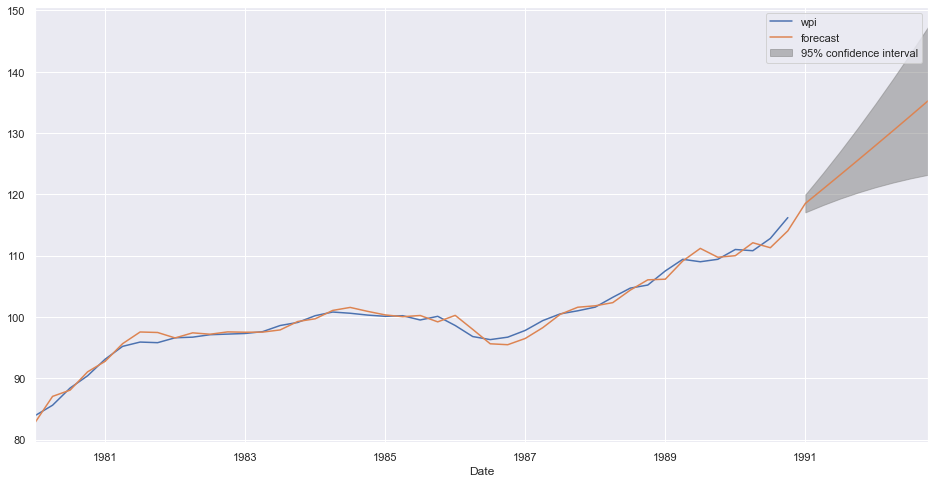

In [22]:
# Plot forecasts
fig, ax = plt.subplots(figsize=(16,8))
# subsetting the data to get a better look at the forecasts
ax = data.loc['1980-01-01':]['wpi'].plot(ax=ax)
res.plot_predict(start='1980Q2',end='1992Q4',
                 ax=ax, plot_insample=False)
ax.set_xlabel('Date')
plt.show();